# 머신 러닝 교과서 3판

# 14장 - 텐서플로의 구조 자세히 알아보기 (1/3)

## 텐서플로의 주요 특징

## 텐서플로의 계산 그래프: 텐서플로 v2로 이전하기

### 계산 그래프 이해하기

### 텐서플로 v1.x에서 그래프 만들기

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.13.0'

In [3]:
## TF-v1.x 스타일
g = tf.Graph()
with g.as_default():
    a = tf.constant(1, name='a')
    b = tf.constant(2, name='b')
    c = tf.constant(3, name='c')
    z = 2*(a - b) + c

with tf.compat.v1.Session(graph=g) as sess:
    print('결과: z =', sess.run(z))
    print('결과: z =', z.eval())

결과: z = 1
결과: z = 1


### TensorFlow v2로 이전하기

In [4]:
## TF v2 스타일 -> 즉시 실행
a = tf.constant(1, name='a')
b = tf.constant(2, name='b')
c = tf.constant(3, name='c')

z = 2*(a - b) + c
tf.print('결과: z =', z)

결과: z = 1


### 입력 데이터를 모델에 주입하기: 텐서플로 v1.x 스타일

In [5]:
## TF-v1.x 스타일
g = tf.Graph()
with g.as_default():
    a = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_a')
    b = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_b')
    c = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_c')
    z = 2*(a - b) + c

with tf.compat.v1.Session(graph=g) as sess:
    feed_dict = {a:1, b:2, c:3}
    print('결과: z =', sess.run(z, feed_dict=feed_dict))

결과: z = 1


### 입력 데이터를 모델에 주입하기: 텐서플로 v2 스타일

In [6]:
## TF-v2 스타일 -> 단순해지고 명확해짐
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

tf.print('스칼라 입력:', compute_z(1, 2, 3))
tf.print('랭크 1 입력:', compute_z([1], [2], [3]))
tf.print('랭크 2 입력:', compute_z([[1]], [[2]], [[3]]))

스칼라 입력: 1
랭크 1 입력: [1]
랭크 2 입력: [[1]]


## 모델 파라미터를 저장하고 업데이트하기 위한 텐서플로 변수 객체

In [10]:
a = tf.Variable(initial_value=3.14, name='var_a')
b = tf.Variable(initial_value=[1, 2, 3], name='var_b')
c = tf.Variable(initial_value=[True, False], dtype=tf.bool)
d = tf.Variable(initial_value=['abc'], dtype=tf.string)
print(a)
print(b)
print(c)
print(d)

<tf.Variable 'var_a:0' shape=() dtype=float32, numpy=3.14>
<tf.Variable 'var_b:0' shape=(3,) dtype=int32, numpy=array([1, 2, 3])>
<tf.Variable 'Variable:0' shape=(2,) dtype=bool, numpy=array([ True, False])>
<tf.Variable 'Variable:0' shape=(1,) dtype=string, numpy=array([b'abc'], dtype=object)>


In [11]:
a.trainable

True

In [12]:
w = tf.Variable([1, 2, 3], trainable=False) #trainable : 훈련여부

print(w.trainable)

False


In [13]:
print(w.assign([3, 1, 4], read_value=True)) #read_value=True : 값 업데이트 및 새로운 값을 자동 반환
w.assign_add([2, -1, 2], read_value=False) #read_value=False : 값만 업데이트 (새로운 값 반환X)

print(w.value()) #텐서 포맷으로 값을 반환

<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([3, 1, 4])>
tf.Tensor([5 0 6], shape=(3,), dtype=int32)


In [14]:
tf.random.set_seed(1)
init = tf.keras.initializers.GlorotNormal() #랜덤 초기화

tf.print(init(shape=(3,)))

[-0.411385983 -0.0812137052 -0.663435221]


In [15]:
v = tf.Variable(init(shape=(2, 3))) #2x3 크기의 Variable 초기화
tf.print(v)

[[-0.450650781 -0.0889651626 -0.726756871]
 [-0.172826812 -0.37408641 -0.645664871]]


C:\Users\sunk2\AppData\Roaming\Python\Python39\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [16]:
#tr.Module 클래스 안에 변수 정의
class MyModule(tf.Module):
    def __init__(self):
        init = tf.keras.initializers.GlorotNormal()
        self.w1 = tf.Variable(init(shape=(2, 3)), trainable=True)
        self.w2 = tf.Variable(init(shape=(1, 2)), trainable=False)

m = MyModule()
print('모든 변수: ', [v.shape for v in m.variables])
print('훈련 가능한 변수:   ', [v.shape for v in
                        m.trainable_variables])

모든 변수:  [TensorShape([2, 3]), TensorShape([1, 2])]
훈련 가능한 변수:    [TensorShape([2, 3])]


## 자동 미분과 GradientTape을 사용해 그레이디언트 계산하기

### 훈련 가능한 변수에 대한 손실의 그레이디언트 계산하기

In [18]:
#x를 사용하여 z를 계싼하는 선형 회귀 모델
#손실을 최소화하기 위해 w에 대한 기울기 계산 -> 모델 훈련 최적화
import tensorflow as tf

#w,b 값 초기화 작업
w = tf.Variable(1.0) 
b = tf.Variable(0.5)
print(w.trainable, b.trainable)

#x,y 생성
x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])

#기울기 연산 기록
with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z)) #예측값과 실제값 사이의 제곱 오차

# tape.gradient() : w 기울기 계산
dloss_dw = tape.gradient(loss, w)

tf.print('dL/dw : ', dloss_dw) #기울기 출력

True True
dL/dw :  -0.559999764


In [19]:
# 계산된 그레이디언트 확인
#tf.print(-2*x * (-b - w*x + y))

tf.print(2*x * ((w*x + b) - y))

[-0.559999764]


### 훈련하지 않는 변수에 대한 그레이디언트 계산하기

`tape.watch()`를 사용해 훈련하지 않는 텐서를 모니터링합니다

In [20]:
with tf.GradientTape() as tape:
    tape.watch(x) #x를 감시(대상 변수이니)
    z = tf.add(tf.multiply(w, x), b) #z=wx+b
    loss = tf.square(y - z) #(y-z)^2

dloss_dx = tape.gradient(loss, x) #손실에 대한 입력 데이터 x의 그레이디언트를 계산

tf.print('dL/dx:', dloss_dx) #입력 데이터 x에 대한 손실 함수의 그레이디언트를 출력

dL/dx: [-0.399999857]


In [21]:
# 계산된 그레이디언트 검증
tf.print(2*w * ((w*x + b) - y))

[-0.399999857]


### 여러 개의 그레이디언트 계산하기

`persistent=True`를 사용합니다.

In [22]:
with tf.GradientTape(persistent=True) as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
dloss_db = tape.gradient(loss, b)

tf.print('dL/dw:', dloss_dw)
tf.print('dL/db:', dloss_db)

dL/dw: -0.559999764
dL/db: -0.399999857


In [23]:
#옵티마이저 정의
optimizer = tf.keras.optimizers.SGD()

optimizer.apply_gradients(zip([dloss_dw, dloss_db], [w, b]))

tf.print('업데이트된 w:', w)
tf.print('업데이트된 b:', b)

업데이트된 w: 1.0056
업데이트된 b: 0.504


## 케라스 API를 사용해 간단하게 일반적인 구조 구현하기

In [24]:
#두개의 밀집 연결층으로 구성된 모델 만들기
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))

## 변수 지연 생성
model.build(input_shape=(None, 4))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
Total params: 624 (2.44 KB)
Trainable params: 624 (2.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
## 모델의 변수 출력하기
for v in model.variables:
    print('{:20s}'.format(v.name), v.trainable, v.shape)

dense/kernel:0       True (4, 16)
dense/bias:0         True (16,)
dense_1/kernel:0     True (16, 32)
dense_1/bias:0       True (32,)


In [26]:
#첫번째 층에 커널과 절편 변수의 초기좌 지정
#두번째 층에 커널에 L1 규제 지정
model = tf.keras.Sequential()

model.add(
    tf.keras.layers.Dense(
        units=16,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
        bias_initializer=tf.keras.initializers.Constant(2.0)
    ))

model.add(
    tf.keras.layers.Dense(
        units=32,
        activation=tf.keras.activations.sigmoid,
        kernel_regularizer=tf.keras.regularizers.l1
    ))

model.build(input_shape=(None, 4))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                80        
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
Total params: 624 (2.44 KB)
Trainable params: 624 (2.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
#SGD 옵티마이저, 이진 분류를 위한 크로스 엔트로피 손실 함수 사용, 정확도, 정밀도, 재현율을 사용해 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),])

### XOR 분류 문제 풀어보기

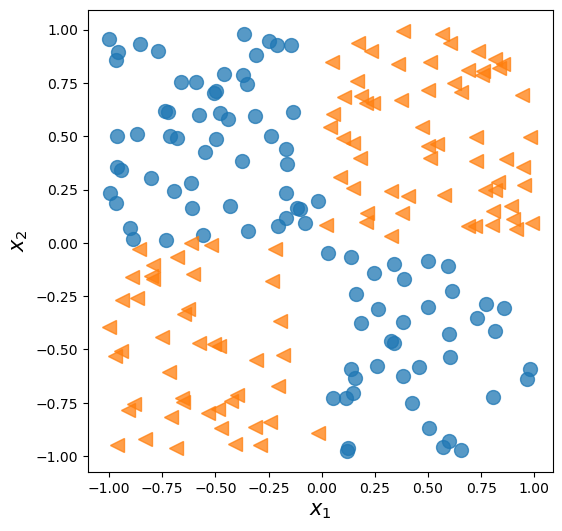

In [28]:
tf.random.set_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2)) #[-1,1) 균등분포 200개 샘플
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

x_train = x[:100, :]
y_train = y[:100]
x_valid = x[100:, :]
y_valid = y[100:]

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0],
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0],
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
# plt.savefig('images/14_1.png', dpi=300)
plt.show()

In [29]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1,
                                input_shape=(2,),
                                activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [31]:
#model.fit : 훈련 에포크의 기록 반환 -> 훈련 후 이를 시각화하여 분석하기 좋음
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

C:\Users\sunk2\AppData\Local\Temp\ipykernel_22804\3286167664.py:19: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


20000/20000 [==============================] - 29s 1ms/step


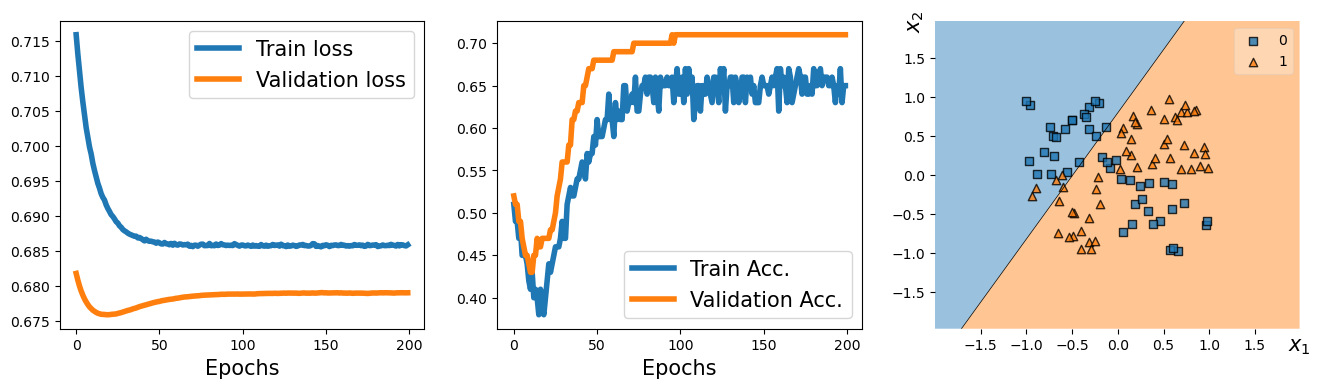

In [32]:
#결정 영역과 훈련 성능 그리기
from mlxtend.plotting import plot_decision_regions

history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()
#손실 / 정확도 / 결정경계

In [33]:
tf.random.set_seed(1)

#3개의 은닉층
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2,), activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()

## 컴파일:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## 훈련:
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

history = hist.history

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4)                 12        
                                                                 
 dense_6 (Dense)             (None, 4)                 20        
                                                                 
 dense_7 (Dense)             (None, 4)                 20        
                                                                 
 dense_8 (Dense)             (None, 1)                 5         
                                                                 
Total params: 57 (228.00 Byte)
Trainable params: 57 (228.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Users\sunk2\AppData\Local\Temp\ipykernel_22804\217449913.py:15: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


20000/20000 [==============================] - 30s 2ms/step


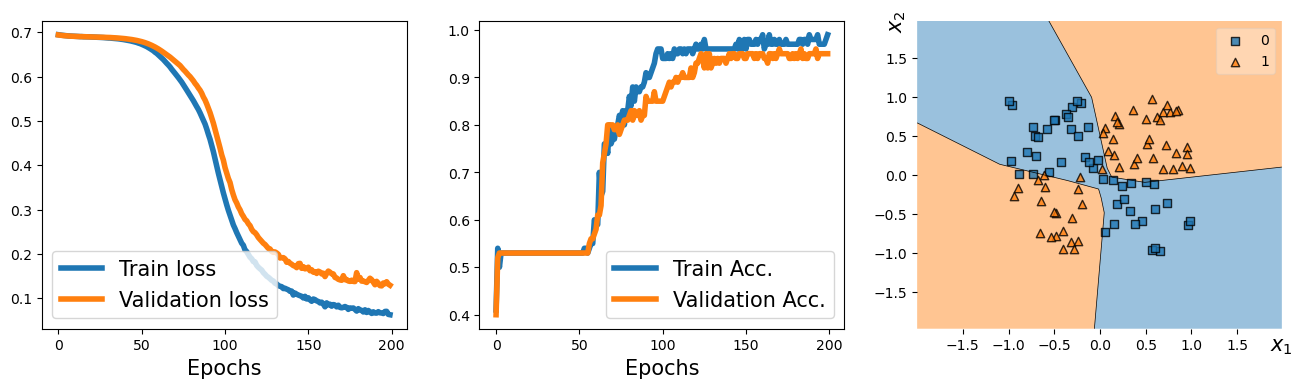

In [34]:
#은닉층을 넣으니 비선형 결정 경계를 찾은 것을 확인할 수 있음
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
# plt.savefig('images/14_3.png', dpi=300)
plt.show()

### 케라스 함수형 API로 유연성이 높은 모델 만들기

In [35]:
tf.random.set_seed(1)

## 입력층
inputs = tf.keras.Input(shape=(2,))

## 은닉층
h1 = tf.keras.layers.Dense(units=4, activation='relu')(inputs)
h2 = tf.keras.layers.Dense(units=4, activation='relu')(h1)
h3 = tf.keras.layers.Dense(units=4, activation='relu')(h2)

## 출력층
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(h3)

## 모델 만들기
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()케

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 12        
                                                                 
 dense_10 (Dense)            (None, 4)                 20        
                                                                 
 dense_11 (Dense)            (None, 4)                 20        
                                                                 
 dense_12 (Dense)            (None, 1)                 5         
                                                                 
Total params: 57 (228.00 Byte)
Trainable params: 57 (228.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Users\sunk2\AppData\Local\Temp\ipykernel_22804\1659542413.py:28: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


20000/20000 [==============================] - 32s 2ms/step


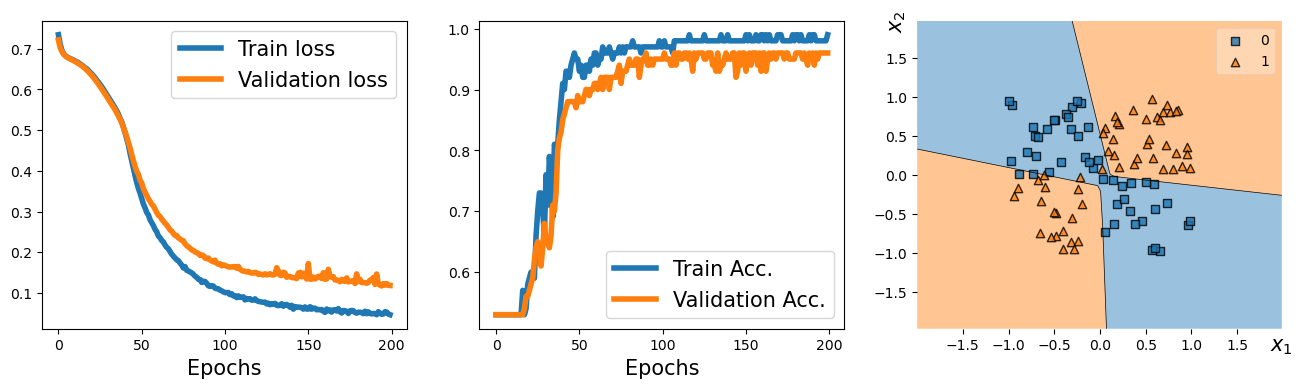

In [36]:
## 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## 훈련
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

## 그래프 그리기
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### 케라사의 Model 클래스 기반으로 모델 만들기

#### `tf.keras.Model` 클래스 상속

 * `__init__()` 구현
 * `call()` 구현

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            multiple                  12        
                                                                 
 dense_14 (Dense)            multiple                  20        
                                                                 
 dense_15 (Dense)            multiple                  20        
                                                                 
 dense_16 (Dense)            multiple                  5         
                                                                 
Total params: 57 (228.00 Byte)
Trainable params: 57 (228.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Users\sunk2\AppData\Local\Temp\ipykernel_22804\2193701909.py:50: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


20000/20000 [==============================] - 33s 2ms/step


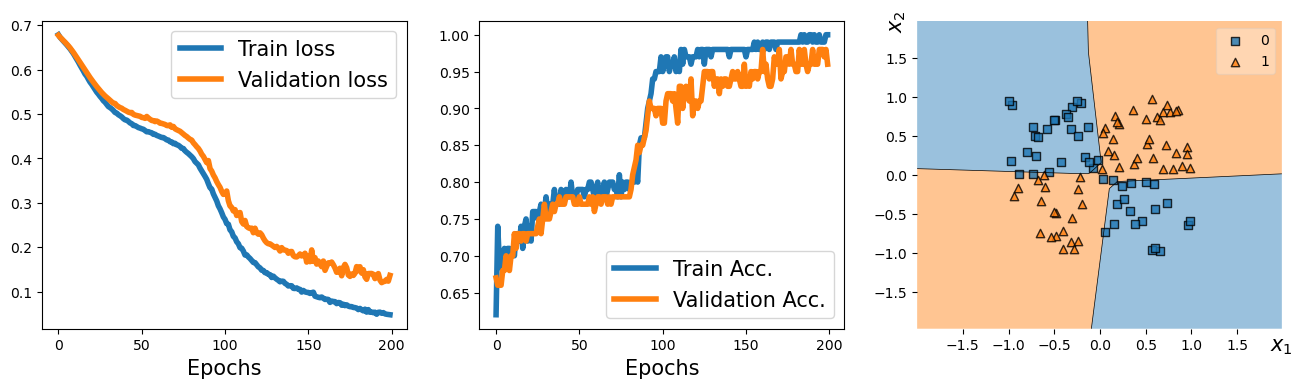

In [37]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_2 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_3 = tf.keras.layers.Dense(units=4, activation='relu')
        self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')

    def call(self, inputs):
        h = self.hidden_1(inputs)
        h = self.hidden_2(h)
        h = self.hidden_3(h)
        return self.output_layer(h)

tf.random.set_seed(1)

## 테스트
model = MyModel()
model.build(input_shape=(None, 2))

model.summary()

## 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## 훈련
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

## 그래프 그리기
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### 사용자 정의 케라스 층 만들기


#### 사용자 정의 층 만들기
 * `__init__()` 구현
 * 변수 지연 생성을 위해 `build()` 구현
 * `call()` 구현
 * 직렬화를 위해 `get_config()` 구현

In [41]:
class NoisyLinear(tf.keras.layers.Layer):
    def __init__(self, output_dim, noise_stddev=0.1, **kwargs):
        self.output_dim = output_dim
        self.noise_stddev = noise_stddev
        super(NoisyLinear, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w = self.add_weight(name='weights',
                                 shape=(input_shape[1], self.output_dim),
                                 initializer='random_normal',
                                 trainable=True)

        self.b = self.add_weight(shape=(self.output_dim,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs, training=False):
        if training:
            batch = tf.shape(inputs)[0]
            dim = tf.shape(inputs)[1]
            noise = tf.random.normal(shape=(batch, dim),
                                     mean=0.0,
                                     stddev=self.noise_stddev)

            noisy_inputs = tf.add(inputs, noise)
        else:
            noisy_inputs = inputs
        z = tf.matmul(noisy_inputs, self.w) + self.b
        return tf.keras.activations.relu(z)

    def get_config(self):
        config = super(NoisyLinear, self).get_config()
        config.update({'output_dim': self.output_dim,
                       'noise_stddev': self.noise_stddev})
        return config


## 테스트

tf.random.set_seed(1)

noisy_layer = NoisyLinear(4)
noisy_layer.build(input_shape=(None, 4))

x = tf.zeros(shape=(1, 4))
tf.print(noisy_layer(x, training=True))

## 설정을 사용해 모델 만들기
config = noisy_layer.get_config()
new_layer = NoisyLinear.from_config(config)
tf.print(new_layer(x, training=True))

[[0 0 0.002378545 0]]
[[0 0 0.000228015619 0.00115264556]]


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noisy_linear_1 (NoisyLinea  (None, 4)                 12        
 r)                                                              
                                                                 
 dense_21 (Dense)            (None, 4)                 20        
                                                                 
 dense_22 (Dense)            (None, 4)                 20        
                                                                 
 dense_23 (Dense)            (None, 1)                 5         
                                                                 
Total params: 57 (228.00 Byte)
Trainable params: 57 (228.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Users\sunk2\AppData\Local\Temp\ipykernel_22804\2398563354.py:40: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


20000/20000 [==============================] - 31s 2ms/step


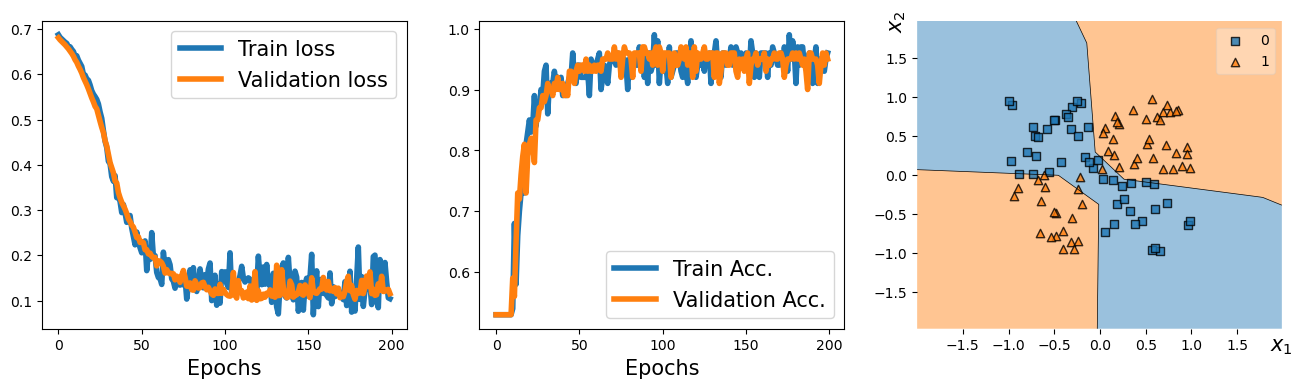

In [42]:
tf.random.set_seed(1)

model = tf.keras.Sequential([
    NoisyLinear(4, noise_stddev=0.1),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

model.build(input_shape=(None, 2))
model.summary()

## 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## 훈련
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2,
                 verbose=0)

## 그래프 그리기
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
# plt.savefig('images/14_4.png', dpi=300)
plt.show()